# Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,plot_confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Carregamento e Pré-Processamento dos Dados

In [2]:
ds = pd.read_csv('../datasets/compas-propublica/compas-scores-two-years.csv')

def preProcess(ds):
    # select African-American and Caucasian people
    ds = ds[(ds['race'] == 'African-American') | (ds['race'] == 'Caucasian')]
    
    # drop duplicated feature columns
    ds.drop(ds[['decile_score.1', 'screening_date', 'v_screening_date', 'priors_count.1']], axis=1, inplace=True)

    # convert dates in string to date/time format
    ds['compas_screening_date'] = pd.to_datetime(ds['compas_screening_date'])
    ds['dob'] = pd.to_datetime(ds['dob'])
    ds['c_jail_in'] = pd.to_datetime(ds['c_jail_in'])
    ds['c_jail_out'] = pd.to_datetime(ds['c_jail_out'])
    ds['c_offense_date'] = pd.to_datetime(ds['c_offense_date'])
    ds['c_arrest_date'] = pd.to_datetime(ds['c_arrest_date'])
    ds['r_offense_date'] = pd.to_datetime(ds['r_offense_date'])
    ds['r_jail_in'] = pd.to_datetime(ds['r_jail_in'])
    ds['r_jail_out'] = pd.to_datetime(ds['r_jail_out'])
    ds['vr_offense_date'] = pd.to_datetime(ds['vr_offense_date'])
    ds['in_custody'] = pd.to_datetime(ds['in_custody'])
    ds['out_custody'] = pd.to_datetime(ds['out_custody'])

    # converting sex categorical variable in numeric variable
    sex = {'Female':1, 'Male':2}
    ds['sex'] = ds['sex'].map(sex)
    # converting race categorical variable in numeric variable
    race = {'African-American':1, 'Caucasian':2}
    ds['race'] = ds['race'].map(race)
    # converting c_charge_degree categorical variable in numeric variable
    c_charge_degree = {'F':1, 'M':2}
    ds['c_charge_degree'] = ds['c_charge_degree'].map(c_charge_degree)
    # converting r_charge_degree and vr_charge_degree categorical variables in numeric variables
    r_vr_charge_degree = {np.nan:0, '(CO3)':1, '(F1)':2, '(F2)':3, '(F3)':4, '(F5)':5, '(F6)':6, '(F7)':7, '(M1)':8, '(M2)':9, '(MO3)':10}
    ds['r_charge_degree'] = ds['r_charge_degree'].map(r_vr_charge_degree)
    ds['vr_charge_degree'] = ds['vr_charge_degree'].map(r_vr_charge_degree)

    # replace nan values in number 1000
    ds['days_b_screening_arrest'] = [1000 if np.isnan(days) else days for days in ds['days_b_screening_arrest']]
    ds['r_days_from_arrest'] = [1000 if np.isnan(days) else days for days in ds['r_days_from_arrest']]

    # calculate the prison days and turns into int values type
    ds['prison_days'] = (ds['c_jail_out'] - ds['c_jail_in'])
    ds['prison_days'] = [str(days).split()[0] for days in ds['prison_days']]
    ds['prison_days'] = [1000 if days=='NaT' else int(days) for days in ds['prison_days']]
    ds['prison_days'] = pd.to_numeric(ds['prison_days'])

    # calculate the custody days and turns into int values type
    ds['custody_days'] = (ds['out_custody'] - ds['in_custody'])
    ds['custody_days'] = [str(days).split()[0] for days in ds['custody_days']]
    ds['custody_days'] = [1000 if days=='NaT' else int(days) for days in ds['custody_days']]
    ds['custody_days'] = pd.to_numeric(ds['custody_days'])

    # classificate medium and high score like highscore and convert to 0 and 1
    ds['score_binary'] = np.where(ds['score_text'] != 'Low', 1, 0)

    return ds

ds = preProcess(ds)

C:\Users\rodolfo\AppData\Local\Temp\ipykernel_6128\2175934616.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds.drop(ds[['decile_score.1', 'screening_date', 'v_screening_date', 'priors_count.1']], axis=1, inplace=True)
C:\Users\rodolfo\AppData\Local\Temp\ipykernel_6128\2175934616.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['compas_screening_date'] = pd.to_datetime(ds['compas_screening_date'])
C:\Users\rodolfo\AppData\Local\Temp\ipykernel_6128\2175934616.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

## Testes de Visualizações

In [3]:
# variaveis categoricas: 'sex', 'race', 'c_charge_degree', 'r_charge_degree', 'vr_charge_degree'

#print(ds['race'].value_counts().to_string())
#print(ds['days_b_screening_arrest'].value_counts().sort_values())

#print(ds['r_days_from_arrest'].isna().sum())

#print(ds[(ds['race'] == 1) | (ds['race'] == 3)]['race'].value_counts())

#print(ds.dtypes)

#print(ds['days_b_screening_arrest'][3])

In [4]:
# for i in range(len(ds)):
#     if ds.loc[i]['priors_count'] != ds.loc[i]['priors_count.1']:
#         print(i, ds.loc[i]['priors_count'], ds.loc[i]['priors_count.1'])

# for i in range(len(ds)):
#     print(i, ds.loc[i]['is_recid'], ds.loc[i]['y_pred'])

In [5]:
# for linha in ds.index:
#     if ds['c_jail_in'][linha] > ds['c_jail_out'][linha]:
#         print(linha, ds['c_jail_in'][linha], ds['c_jail_out'][linha])

# Seleção dos Atributos de Treino e Rótulo

In [6]:
# 17 features for classification usage
data_x = ds[['sex', 'age', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_charge_degree', 'is_recid', 'r_charge_degree', 'r_days_from_arrest', 'is_violent_recid', 'vr_charge_degree', 'prison_days', 'custody_days']]

data_y = ds['two_year_recid']

prev_compas = ds['score_binary']

# Divisão do Dataset para Treino e Teste

In [7]:
# 6150 total lines

qtd70 = (len(data_x) * 70) // 100

# 4305 train lines
train_x = data_x[:qtd70]
train_y = data_y[:qtd70]

# 1845 test lines
test_x = data_x[qtd70:]
test_y = data_y[qtd70:]
test_prev_compas = prev_compas[qtd70:]

# Carregamento e Execução de Modelos

## Execução 1 - Todas as Colunas

Utilizando todos os atributos (17 no total) filtrados favoráveis à classificação.

In [8]:
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

rf.fit(train_x, train_y)
gb.fit(train_x, train_y)

ex1_prev_rf = rf.predict(test_x)
ex1_prev_gb = gb.predict(test_x)

## Execução 2 - Sem Atributo de Sexo

Retirando a utilização do atributo de sexo, utilizando 16 no total.

In [9]:
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

features = ['age', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_charge_degree', 'is_recid', 'r_charge_degree', 'r_days_from_arrest', 'is_violent_recid', 'vr_charge_degree', 'prison_days', 'custody_days']

rf.fit(train_x[features], train_y)
gb.fit(train_x[features], train_y)

ex2_prev_rf = rf.predict(test_x[features])
ex2_prev_gb = gb.predict(test_x[features])

## Execução 3 - Sem Atributo de Raça

Retirando a utilização do atributo de raça, utilizando 16 no total.

In [10]:
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

features = ['sex', 'age', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_charge_degree', 'is_recid', 'r_charge_degree', 'r_days_from_arrest', 'is_violent_recid', 'vr_charge_degree', 'prison_days', 'custody_days']

rf.fit(train_x[features], train_y)
gb.fit(train_x[features], train_y)

ex3_prev_rf = rf.predict(test_x[features])
ex3_prev_gb = gb.predict(test_x[features])

## Execução 4 - Sem os Atributo de Sexo e Raça

Retirando a utilização dos atributos de sexo e raça, utilizando 15 no total.

In [11]:
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

features = ['age', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_charge_degree', 'is_recid', 'r_charge_degree', 'r_days_from_arrest', 'is_violent_recid', 'vr_charge_degree', 'prison_days', 'custody_days']

rf.fit(train_x[features], train_y)
gb.fit(train_x[features], train_y)

ex4_prev_rf = rf.predict(test_x[features])
ex4_prev_gb = gb.predict(test_x[features])

# Cálculo de Métricas

Comparação das previsões com os valores verdadeiros para o dataset e também com a previsão feita pelo COMPAS.

## Execução 1

### Random Forest

In [12]:
# calculating metrics of prevision and true values
ex1_rf_accuracy = accuracy_score(test_y, ex1_prev_rf)
ex1_rf_precision = precision_score(test_y, ex1_prev_rf)
ex1_rf_recall = recall_score(test_y, ex1_prev_rf)
ex1_rf_matrix = confusion_matrix(test_y, ex1_prev_rf)

# calculating metrics of prevision and compas prevision
ex1_compas_rf_accuracy = accuracy_score(test_prev_compas, ex1_prev_rf)
ex1_compas_rf_precision = precision_score(test_prev_compas, ex1_prev_rf)
ex1_compas_rf_recall = recall_score(test_prev_compas, ex1_prev_rf)
ex1_compas_rf_matrix = confusion_matrix(test_prev_compas, ex1_prev_rf)

(0.5, 1.02)

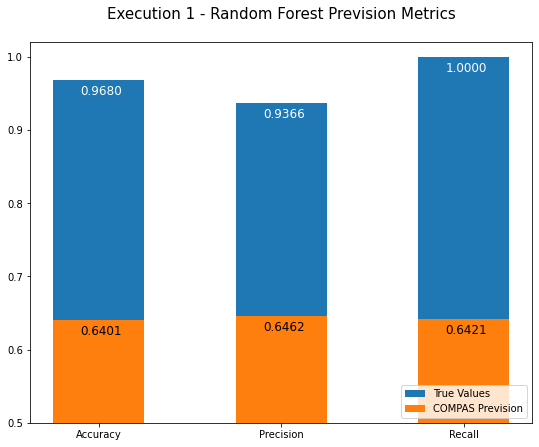

In [13]:
labels = ['Accuracy', 'Precision', 'Recall']

plt.subplots(figsize=(9, 7))
plt.title('Execution 1 - Random Forest Prevision Metrics\n', loc='center', fontsize=15)
plt.bar(labels, [ex1_rf_accuracy, ex1_rf_precision, ex1_rf_recall], width=.5)
for index, data in enumerate([ex1_rf_accuracy, ex1_rf_precision, ex1_rf_recall]):
    plt.text(x=index-0.1, y=data-0.02, s=f"{data:.4f}" , fontdict=dict(fontsize=12), color='white')
plt.bar(labels, [ex1_compas_rf_accuracy, ex1_compas_rf_precision, ex1_compas_rf_recall], width=.5)
for index, data in enumerate([ex1_compas_rf_accuracy, ex1_compas_rf_precision, ex1_compas_rf_recall]):
    plt.text(x=index-0.1, y=data-0.02, s=f"{data:.4f}" , fontdict=dict(fontsize=12), color='black')
plt.legend(labels=['True Values', 'COMPAS Prevision'], loc='lower right')
plt.ylim(0.5,1.02)

Text(60.0, 0.5, 'True Values\n')

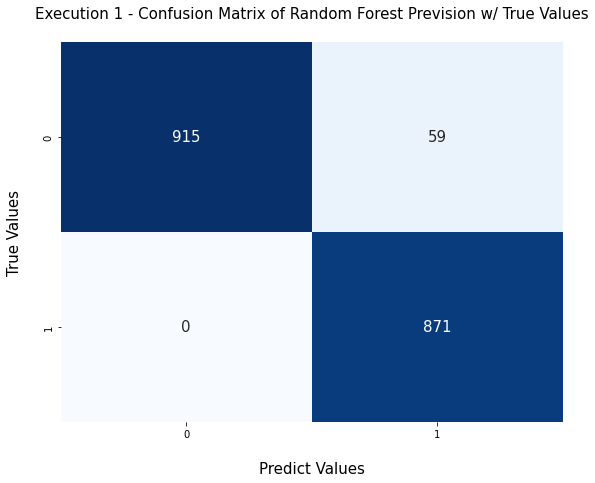

In [14]:
# confusion matrix graph
plt.subplots(figsize=(9, 7))
sns.heatmap(ex1_rf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, annot_kws={"fontsize":15})
plt.title('Execution 1 - Confusion Matrix of Random Forest Prevision w/ True Values\n', loc='center', fontsize=15)
plt.xlabel('\nPredict Values', fontsize=15)
plt.ylabel('True Values\n', fontsize=15)

## Execução 2

### Random Forest

In [15]:
# calculating metrics of prevision and true values
ex2_rf_accuracy = accuracy_score(test_y, ex2_prev_rf)
ex2_rf_precision = precision_score(test_y, ex2_prev_rf)
ex2_rf_recall = recall_score(test_y, ex2_prev_rf)
ex2_rf_matrix = confusion_matrix(test_y, ex2_prev_rf)

# calculating metrics of prevision and compas prevision
ex2_compas_rf_accuracy = accuracy_score(test_prev_compas, ex2_prev_rf)
ex2_compas_rf_precision = precision_score(test_prev_compas, ex2_prev_rf)
ex2_compas_rf_recall = recall_score(test_prev_compas, ex2_prev_rf)
ex2_compas_rf_matrix = confusion_matrix(test_prev_compas, ex2_prev_rf)

(0.5, 1.02)

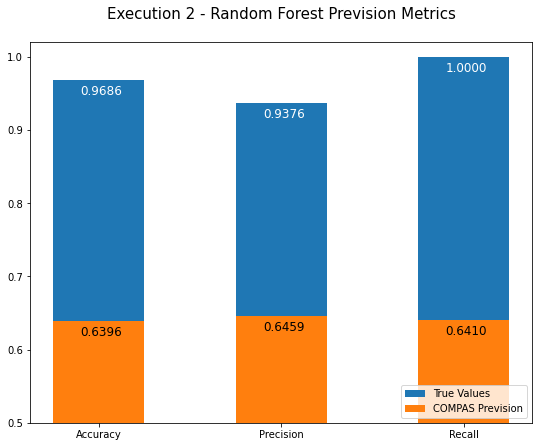

In [16]:
labels = ['Accuracy', 'Precision', 'Recall']

plt.subplots(figsize=(9, 7))
plt.title('Execution 2 - Random Forest Prevision Metrics\n', loc='center', fontsize=15)
plt.bar(labels, [ex2_rf_accuracy, ex2_rf_precision, ex2_rf_recall], width=.5)
for index, data in enumerate([ex2_rf_accuracy, ex2_rf_precision, ex2_rf_recall]):
    plt.text(x=index-0.1, y=data-0.02, s=f"{data:.4f}" , fontdict=dict(fontsize=12), color='white')
plt.bar(labels, [ex2_compas_rf_accuracy, ex2_compas_rf_precision, ex2_compas_rf_recall], width=.5)
for index, data in enumerate([ex2_compas_rf_accuracy, ex2_compas_rf_precision, ex2_compas_rf_recall]):
    plt.text(x=index-0.1, y=data-0.02, s=f"{data:.4f}" , fontdict=dict(fontsize=12), color='black')
plt.legend(labels=['True Values', 'COMPAS Prevision'], loc='lower right')
plt.ylim(0.5,1.02)

Text(60.0, 0.5, 'True Values\n')

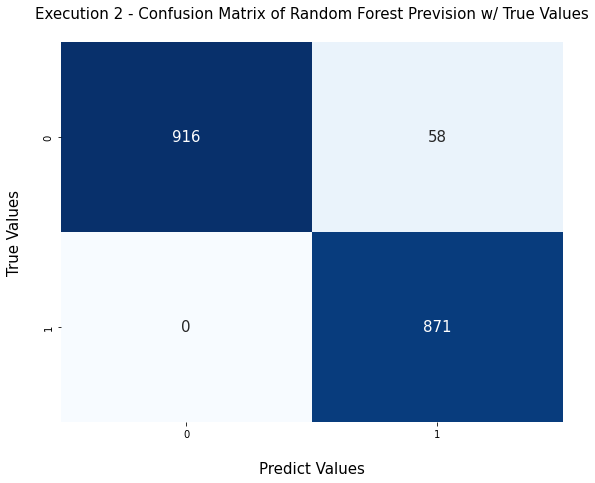

In [17]:
# confusion matrix graph
plt.subplots(figsize=(9, 7))
sns.heatmap(ex2_rf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, annot_kws={"fontsize":15})
plt.title('Execution 2 - Confusion Matrix of Random Forest Prevision w/ True Values\n', loc='center', fontsize=15)
plt.xlabel('\nPredict Values', fontsize=15)
plt.ylabel('True Values\n', fontsize=15)

## Execução 3

### Random Forest

In [18]:
# calculating metrics of prevision and true values
ex3_rf_accuracy = accuracy_score(test_y, ex3_prev_rf)
ex3_rf_precision = precision_score(test_y, ex3_prev_rf)
ex3_rf_recall = recall_score(test_y, ex3_prev_rf)
ex3_rf_matrix = confusion_matrix(test_y, ex3_prev_rf)

# calculating metrics of prevision and compas prevision
ex3_compas_rf_accuracy = accuracy_score(test_prev_compas, ex3_prev_rf)
ex3_compas_rf_precision = precision_score(test_prev_compas, ex3_prev_rf)
ex3_compas_rf_recall = recall_score(test_prev_compas, ex3_prev_rf)
ex3_compas_rf_matrix = confusion_matrix(test_prev_compas, ex3_prev_rf)

(0.5, 1.02)

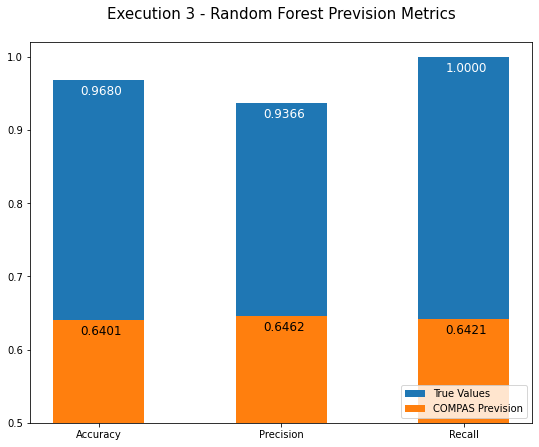

In [19]:
labels = ['Accuracy', 'Precision', 'Recall']

plt.subplots(figsize=(9, 7))
plt.title('Execution 3 - Random Forest Prevision Metrics\n', loc='center', fontsize=15)
plt.bar(labels, [ex3_rf_accuracy, ex3_rf_precision, ex3_rf_recall], width=.5)
for index, data in enumerate([ex3_rf_accuracy, ex3_rf_precision, ex3_rf_recall]):
    plt.text(x=index-0.1, y=data-0.02, s=f"{data:.4f}" , fontdict=dict(fontsize=12), color='white')
plt.bar(labels, [ex3_compas_rf_accuracy, ex3_compas_rf_precision, ex3_compas_rf_recall], width=.5)
for index, data in enumerate([ex3_compas_rf_accuracy, ex3_compas_rf_precision, ex3_compas_rf_recall]):
    plt.text(x=index-0.1, y=data-0.02, s=f"{data:.4f}" , fontdict=dict(fontsize=12), color='black')
plt.legend(labels=['True Values', 'COMPAS Prevision'], loc='lower right')
plt.ylim(0.5,1.02)

Text(60.0, 0.5, 'True Values\n')

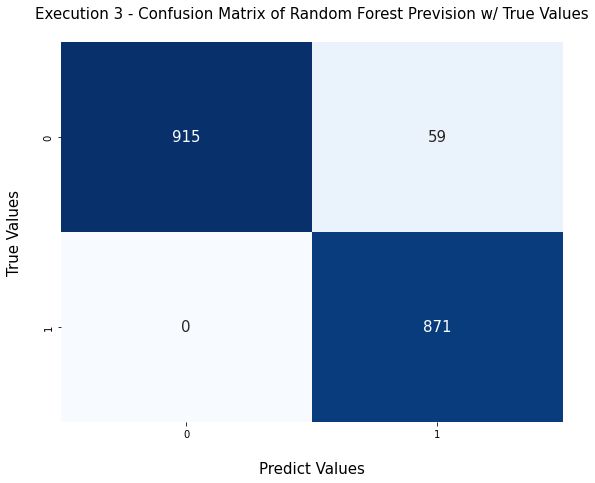

In [20]:
# confusion matrix graph
plt.subplots(figsize=(9, 7))
sns.heatmap(ex3_rf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, annot_kws={"fontsize":15})
plt.title('Execution 3 - Confusion Matrix of Random Forest Prevision w/ True Values\n', loc='center', fontsize=15)
plt.xlabel('\nPredict Values', fontsize=15)
plt.ylabel('True Values\n', fontsize=15)

## Execução 4

### Random Forest

In [21]:
# calculating metrics of prevision and true values
ex4_rf_accuracy = accuracy_score(test_y, ex4_prev_rf)
ex4_rf_precision = precision_score(test_y, ex4_prev_rf)
ex4_rf_recall = recall_score(test_y, ex4_prev_rf)
ex4_rf_matrix = confusion_matrix(test_y, ex4_prev_rf)

# calculating metrics of prevision and compas prevision
ex4_compas_rf_accuracy = accuracy_score(test_prev_compas, ex4_prev_rf)
ex4_compas_rf_precision = precision_score(test_prev_compas, ex4_prev_rf)
ex4_compas_rf_recall = recall_score(test_prev_compas, ex4_prev_rf)
ex4_compas_rf_matrix = confusion_matrix(test_prev_compas, ex4_prev_rf)

(0.5, 1.02)

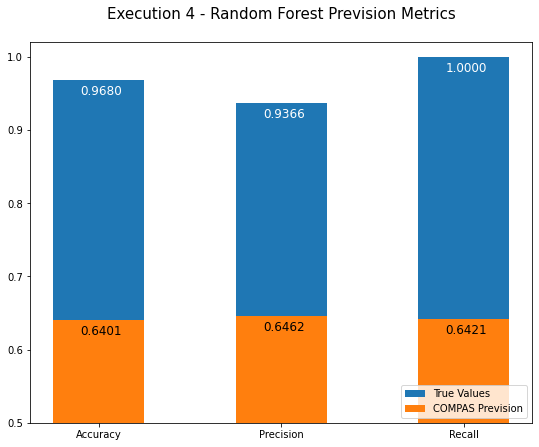

In [22]:
labels = ['Accuracy', 'Precision', 'Recall']

plt.subplots(figsize=(9, 7))
plt.title('Execution 4 - Random Forest Prevision Metrics\n', loc='center', fontsize=15)
plt.bar(labels, [ex4_rf_accuracy, ex4_rf_precision, ex4_rf_recall], width=.5)
for index, data in enumerate([ex4_rf_accuracy, ex4_rf_precision, ex4_rf_recall]):
    plt.text(x=index-0.1, y=data-0.02, s=f"{data:.4f}" , fontdict=dict(fontsize=12), color='white')
plt.bar(labels, [ex4_compas_rf_accuracy, ex4_compas_rf_precision, ex4_compas_rf_recall], width=.5)
for index, data in enumerate([ex4_compas_rf_accuracy, ex4_compas_rf_precision, ex4_compas_rf_recall]):
    plt.text(x=index-0.1, y=data-0.02, s=f"{data:.4f}" , fontdict=dict(fontsize=12), color='black')
plt.legend(labels=['True Values', 'COMPAS Prevision'], loc='lower right')
plt.ylim(0.5,1.02)

Text(60.0, 0.5, 'True Values\n')

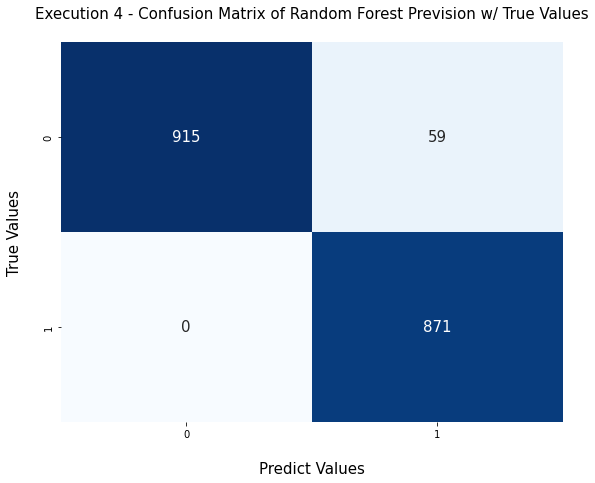

In [23]:
# confusion matrix graph
plt.subplots(figsize=(9, 7))
sns.heatmap(ex4_rf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, annot_kws={"fontsize":15})
plt.title('Execution 4 - Confusion Matrix of Random Forest Prevision w/ True Values\n', loc='center', fontsize=15)
plt.xlabel('\nPredict Values', fontsize=15)
plt.ylabel('True Values\n', fontsize=15)